In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

years = ['2013', '2014', '2015', '2016']
thresholds = list(range(5, 60, 5))

In [2]:
import time
from multiprocessing import cpu_count, Pool

cores = cpu_count()

def import_statistics(file_path, line_skip=7):
    lines = open(file_path).readlines()
    query_count = int(lines[2].strip().split("\t")[1])
    counts = [(set(json.loads(left)), int(right)) for left, right in (line.strip().split("\t") for line in lines[line_skip:])]
    counts = [entry for entry in counts if len(entry[0]) > 0]
    return query_count, pd.DataFrame(counts, columns=["set", "weight"])

def import_combined(file_paths, line_skip=7):
    dfs = []
    total_queries = 0
    for path in file_paths:
        query_count, df = import_statistics(path, line_skip)
        total_queries = total_queries + query_count
        dfs.append(df)
        
    all_df = pd.concat(dfs)
    all_df["set"] = all_df["set"].map(json.dumps)
    all_df = all_df.groupby(all_df["set"]).sum().sort_values(by=['weight'], ascending=False).reset_index()
    all_df["set"] = all_df["set"].map(lambda s: set(json.loads(s)))
    return (all_df, total_queries)
        

def weighted_minimum_union(df, threshold):
    result_set = set()
    result_list = []
    weight_sum = 0
    df = df.copy()
    
    while(weight_sum < threshold):
        if df.shape[0] == 0:
            break
        
        #start = time.time()
        df["remaining"] = df["set"].map(lambda s: s - result_set)
        #print(time.time() - start)
        df["len_remaining"] = df["remaining"].apply(len)
        #print(time.time() - start)
        df["relative_weight"] = df["weight"] / df["len_remaining"]
        #print(time.time() - start)

        top_row = df.sort_values("relative_weight", ascending = False).iloc[0]
        
        if weight_sum + top_row["weight"] < threshold:
            result_set |= top_row["remaining"]
            result_list.extend(top_row["remaining"])
            df,weight_sum = add_all_fully_covered_rows(df, result_set, weight_sum)
        else:
            crossing_threshold = df[df["weight"] >= (threshold - weight_sum)]
            best_crossing = crossing_threshold.sort_values(["len_remaining", "weight"], ascending = [True, False]).iloc[0]
            result_set |= best_crossing["remaining"]
            result_list.extend(best_crossing["remaining"])
            df,weight_sum = add_all_fully_covered_rows(df, result_set, weight_sum)
        #print(time.time() - start)

        #print(result_set)
    return(result_list, weight_sum)
                                   
def add_all_fully_covered_rows(df, result_set, weight_sum):
    fully_covered = df["remaining"].map(lambda remaining: len(remaining - result_set) == 0)
    weight_sum = weight_sum + df[fully_covered]["weight"].sum()
    df = df[~fully_covered]
    return df, weight_sum

def minimum_union_for_thresholds(df, total_queries, thresholds):
    pool = Pool(cores)
    
    minimum_unions = pool.starmap(minimum_union_for_threshold, [(df, total_queries, thres) for thres in thresholds])
    return minimum_unions

def minimum_union_for_threshold(df, total_queries, threshold):
    threshold_value = total_queries * threshold / 100
    result_set, weight_sum = weighted_minimum_union(df, threshold_value)
    return (result_set, weight_sum / total_queries)

def plot_minimum_unions(minimum_unions, axes):
    steps = [list(x) for x in zip(*[(len(result_set), weight_sum) for result_set, weight_sum in minimum_unions])]
    axes.set_ylim(0, 1)
    axes.minorticks_on()
    axes.grid(True, linestyle="--", lw=0.5)
    axes.plot(steps[0], steps[1])
    axes.set_xlabel('partitions')
    axes.set_ylabel('percent of queries')
    


# DBpedia

In [4]:
results = []

for index, year in enumerate(years):
    lines = open(f"../queryshapes{year}_2.txt").readlines()
    total_queries = int(lines[2].strip().split("\t")[1])
    counts = [(json.loads(left), int(right)) for left, right in (line.strip().split("\t") for line in lines[4:])]
    counts = [entry for entry in counts if len(entry[0]) > 0]
    df = pd.DataFrame(counts, columns=["set", "weight"])

    minimum_unions = []
    for threshold in thresholds:
        threshold_value = total_queries * threshold / 100
        result = weighted_minimum_union(df,threshold_value)
        minimum_unions.append(result)
        if result[1] < threshold_value:
            break
    res = [list(x) for x in zip(*[(len(result_set), weight_sum/total_queries) for result_set, weight_sum in minimum_unions])]
    
    results.append(res)
    
#     plt.subplot(221+index)
#     plt.ylim(0, 1)
#     plt.plot(res[0], res[1])
#     plt.title(year)
#     plt.xlabel('partitions')
#     plt.ylabel('percent of queries')
    
# plt.savefig('figure.png', dpi=200)

NameError: name 'years' is not defined

<IPython.core.display.Javascript object>


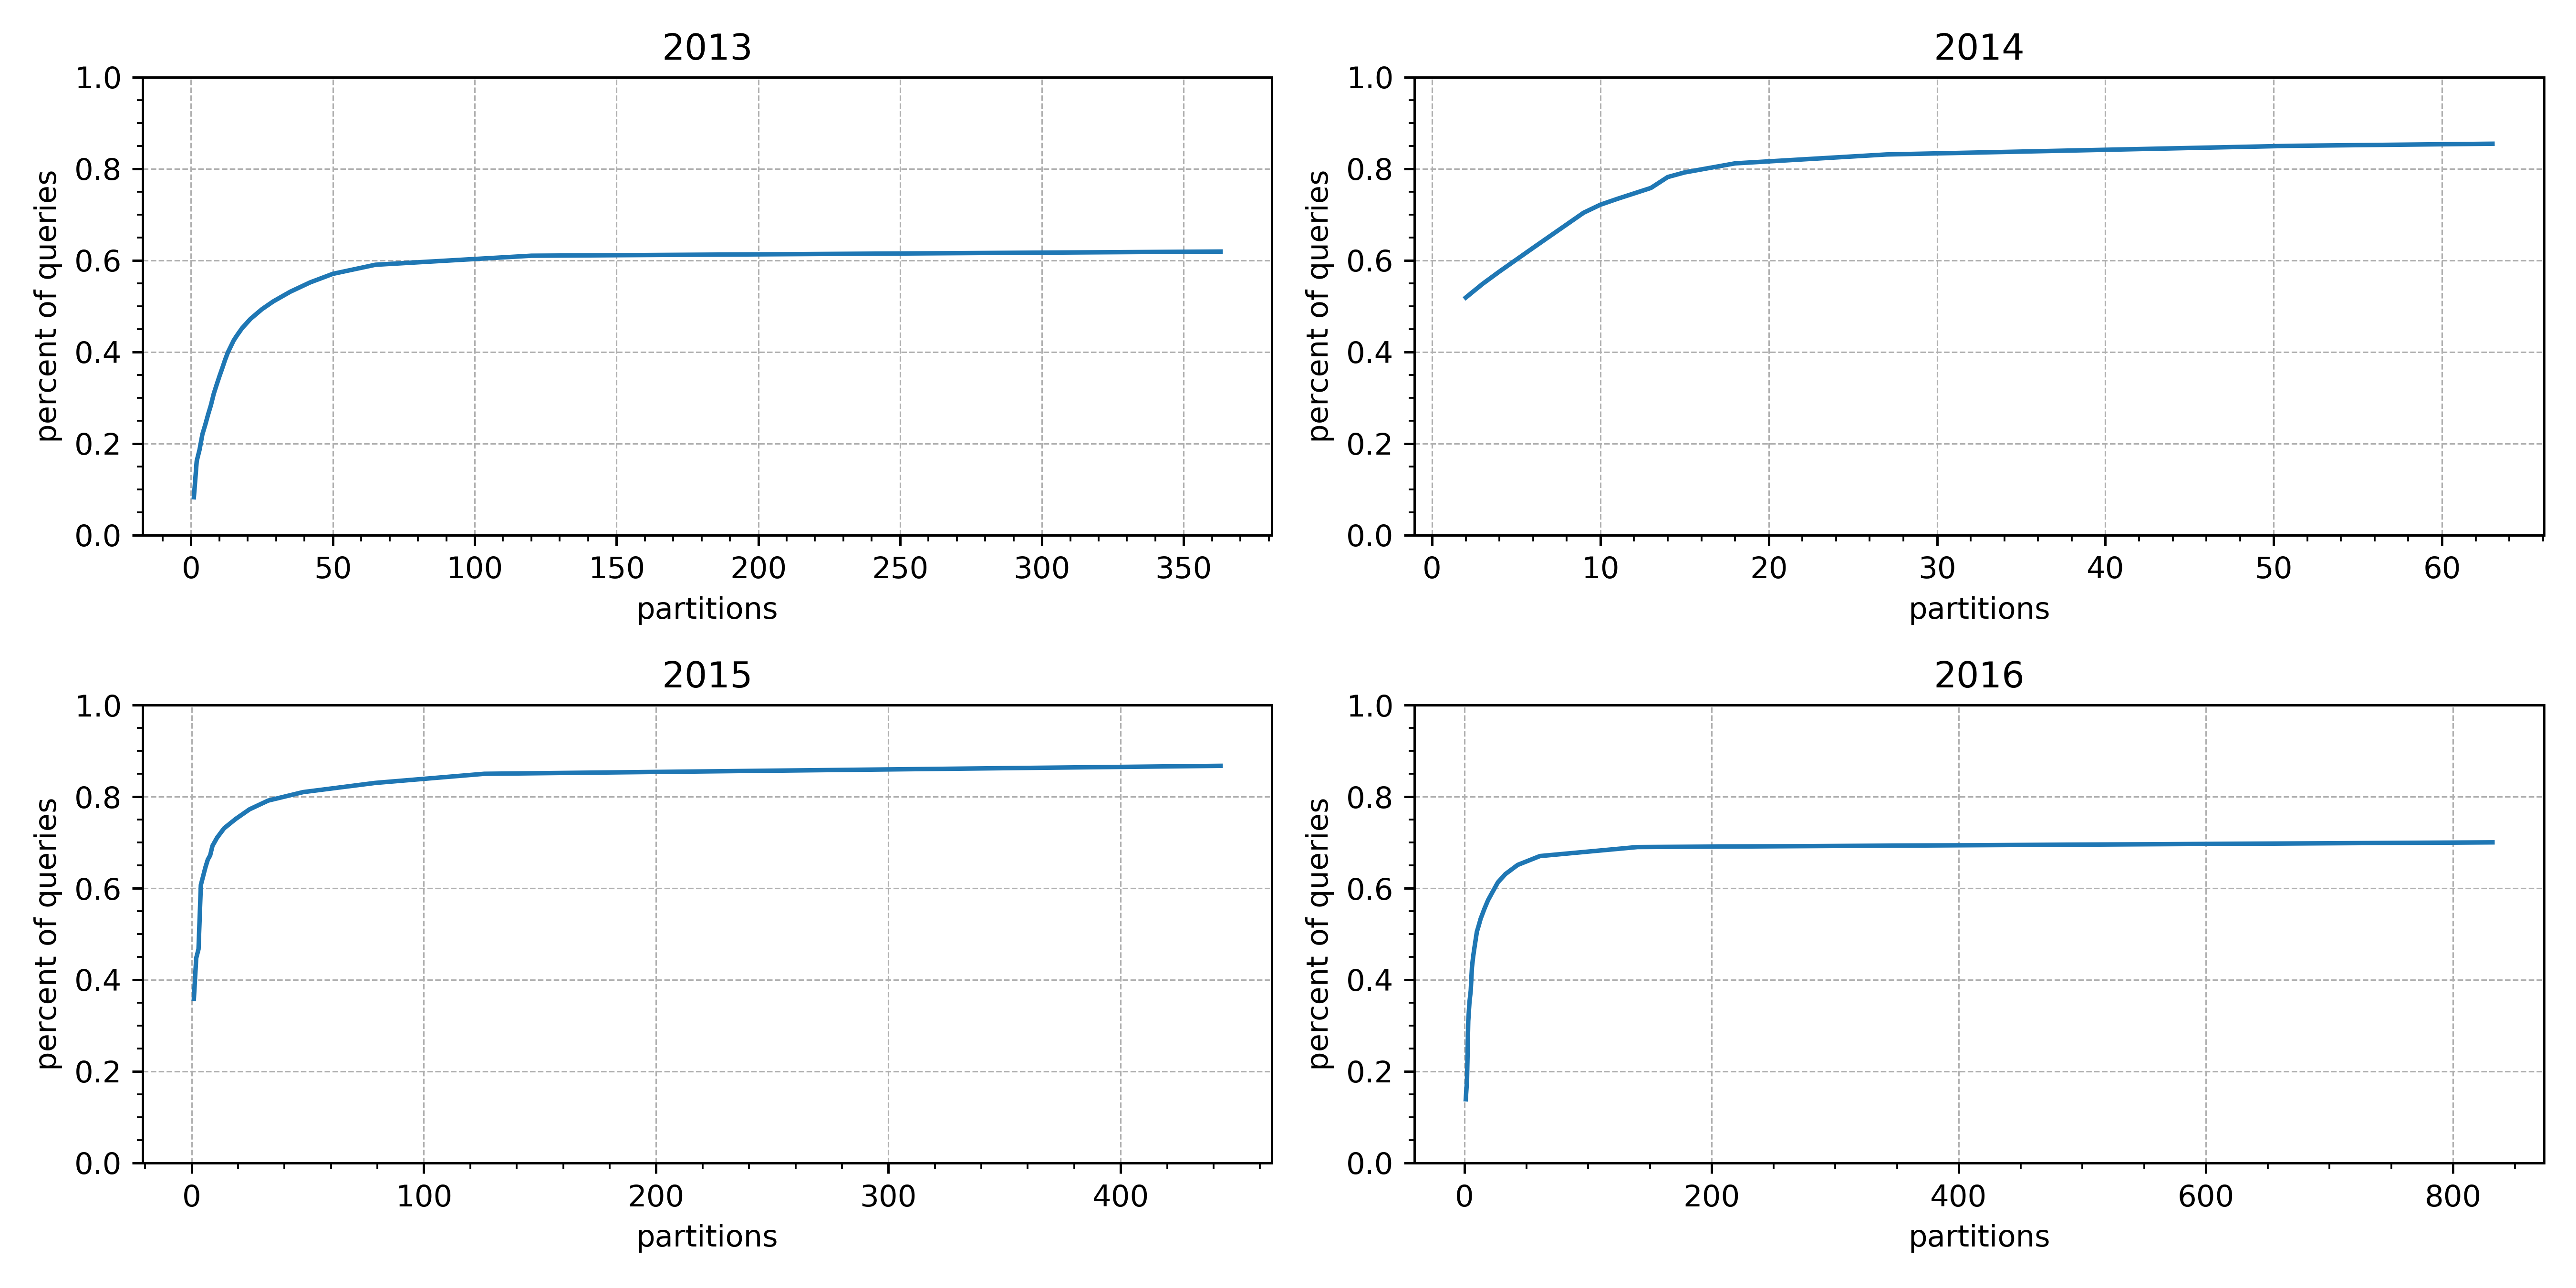

In [82]:
%matplotlib notebook
fig, axes = plt.subplots(2,2,figsize=(12,6),dpi=300)
axli = axes.flatten()
for index, res in enumerate(results):
    axli[index].set_ylim(0, 1)
    axli[index].minorticks_on()
    axli[index].grid(True, linestyle="--", lw=0.5)
    axli[index].plot(res[0], res[1])
    axli[index].set_title(2013+index)
    axli[index].set_xlabel('partitions')
    axli[index].set_ylabel('percent of queries')
    
fig.tight_layout()
fig.savefig("years_seperate.png")

In [39]:
import json
df = pd.concat(year_dfs)
df["set"] = df["set"].map(json.dumps)
df = df.groupby(df["set"]).sum().sort_values(by=['weight'], ascending=False).reset_index()
df["set"] = df["set"].map(lambda s: set(json.loads(s)))

In [85]:
minimum_unions = [weighted_minimum_union(df, total_queries * threshold / 100) for threshold in thresholds]
res_total = [list(x) for x in zip(*[(len(result_set), weight_sum/total_queries) for result_set, weight_sum in minimum_unions])]

<IPython.core.display.Javascript object>


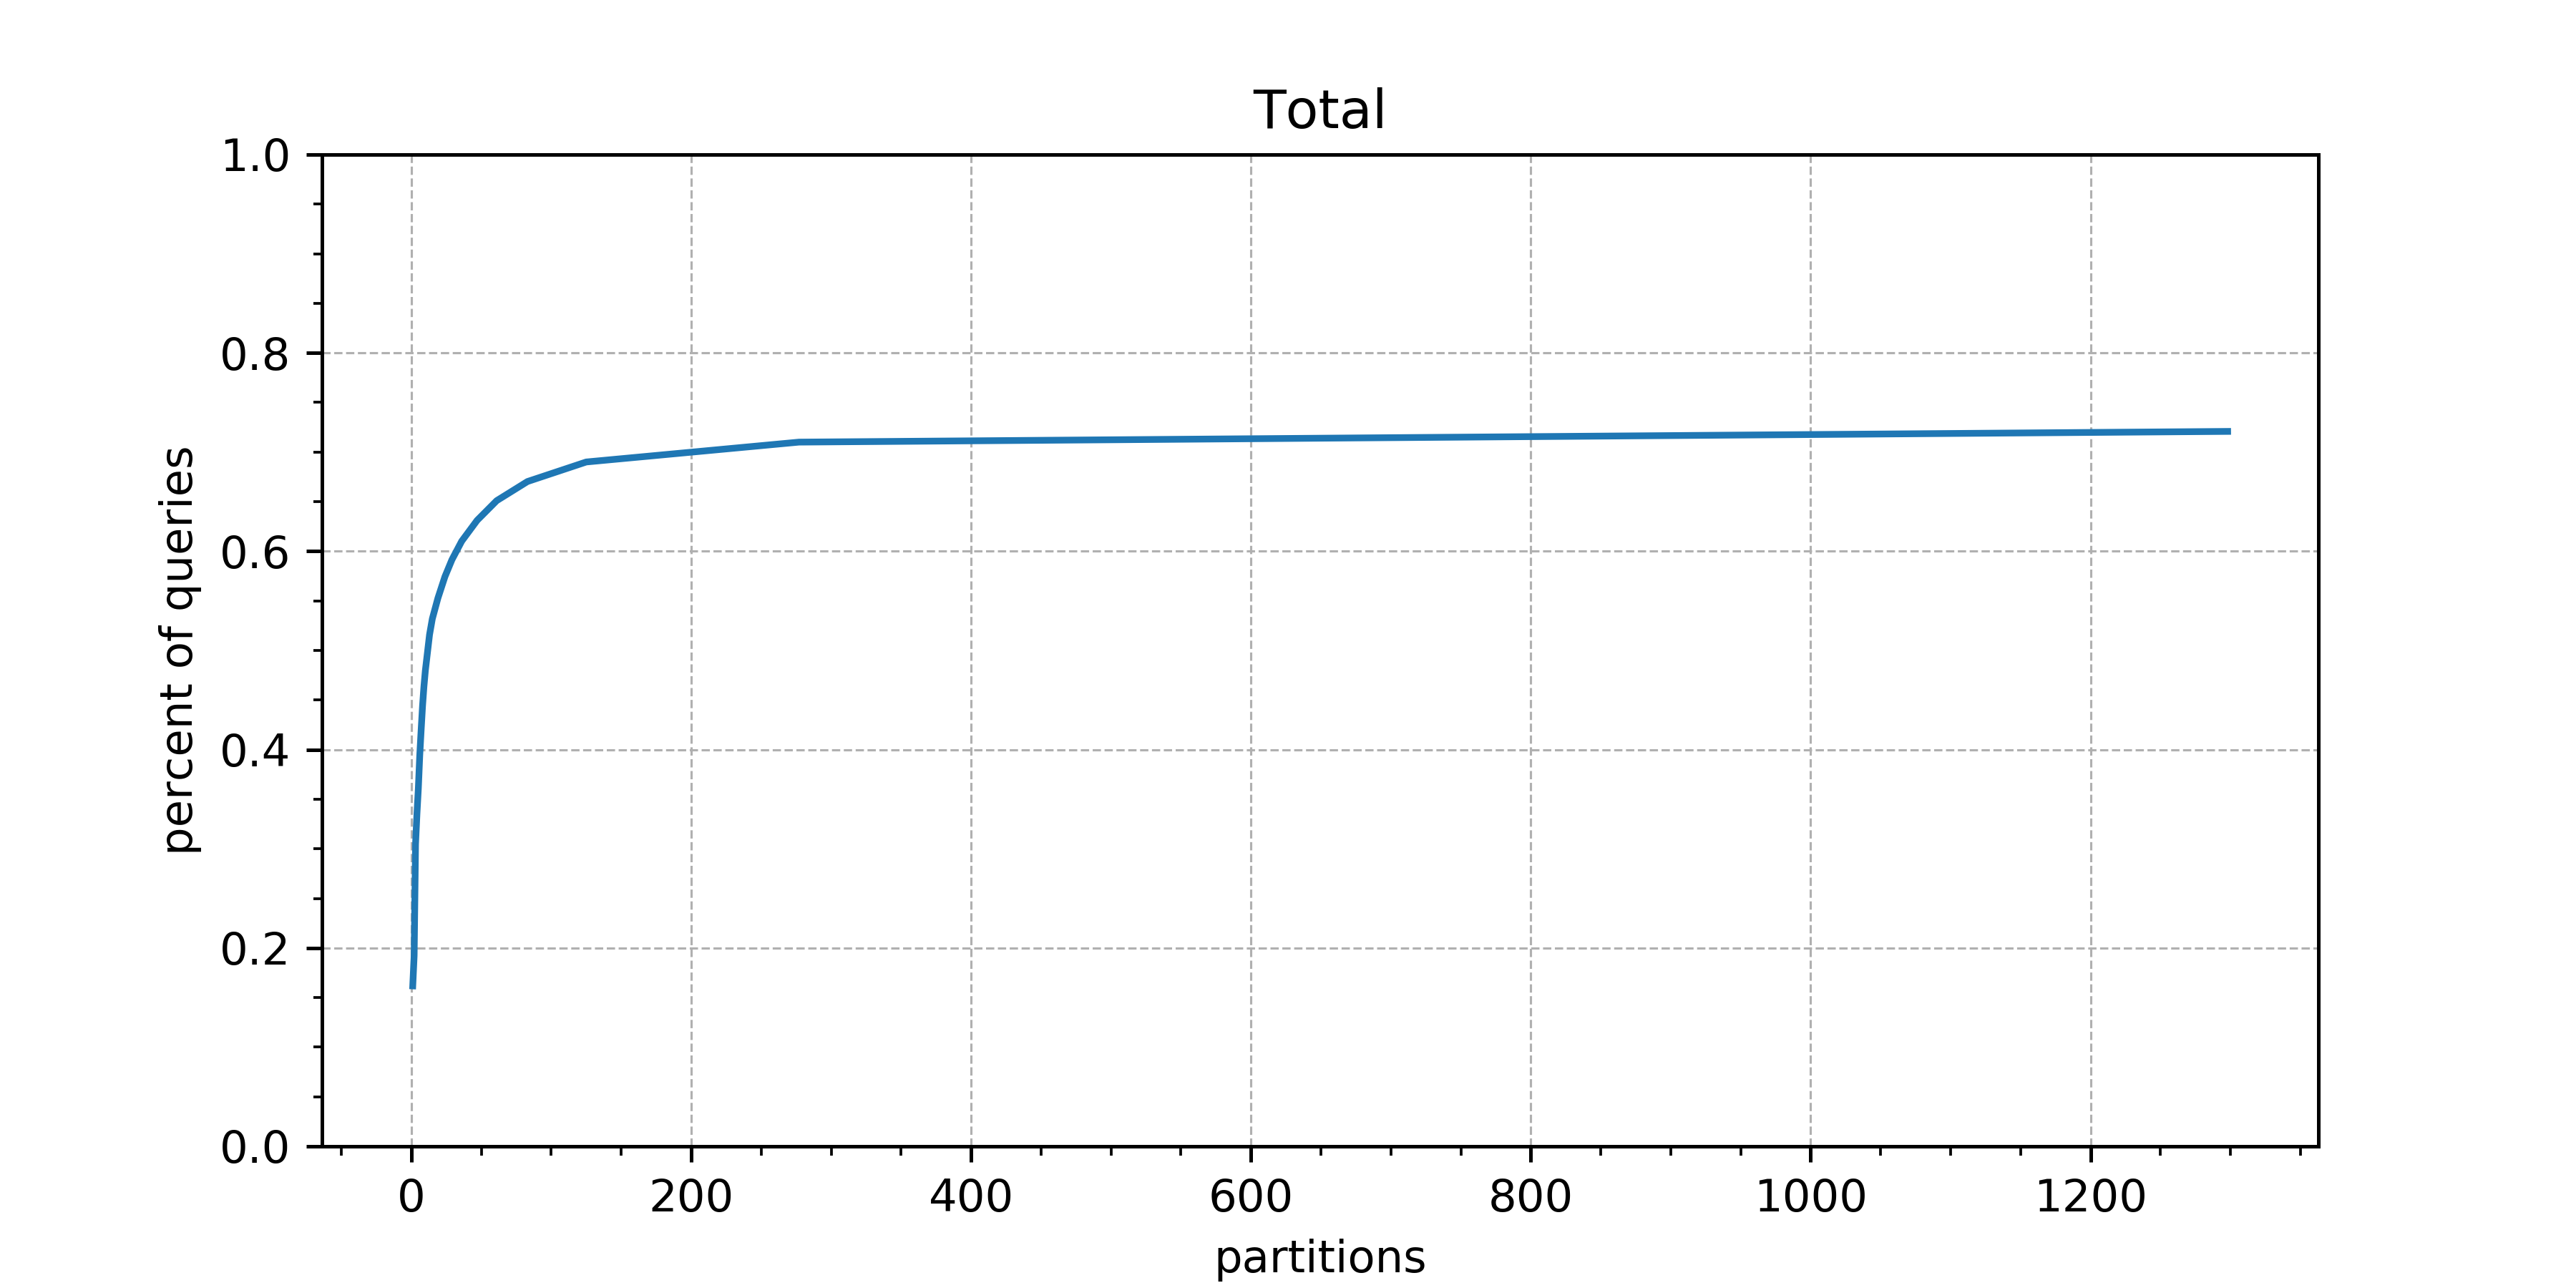

In [87]:
%matplotlib notebook

plt.figure(figsize=(8,4), dpi=300)
plt.ylim(0, 1)
plt.minorticks_on()
plt.grid(True, linestyle="--", lw=0.5)
plt.plot(res_total[0], res_total[1])
plt.title("Total")
plt.xlabel('partitions')
plt.ylabel('percent of queries')
plt.savefig("years_total.png")
plt.show()


In [97]:
minimum_unions1 = [(partitions, weight_sum / total_queries) for partitions, weight_sum in minimum_unions]
minimum_unions_70 = [item for item in minimum_unions1 if item[1] > 0.70 and item[1] < 0.72][0]
minimum_unions_70

(['9',
  '3,9',
  '3,9,79,223,515,1988',
  '3',
  '3,1101',
  '3,16,24,40,49,50,79,109',
  '16',
  '9,711,895,1472,1473,1474,1475,1476,1477',
  '3,16',
  '17',
  '363',
  '89',
  '47',
  '3,49,50',
  '9,17',
  '40',
  '5',
  '32',
  '3,89',
  '9,19',
  '19,236,261',
  '49,50',
  '7',
  '937',
  '3,347',
  '3,2290',
  '9,89',
  '9,16,82,129,317',
  '85',
  '27,47',
  '882',
  '1101',
  '3,5,7,9,61,500,537,951',
  '347',
  '26428',
  '15',
  '19',
  '3,16,40',
  '3,16,40,347',
  '3,9,16,40',
  '3,9,2294',
  '3,5,9,49,50,61,136,1473,1476',
  '3,5',
  '9,19,261,1658',
  '13',
  '3,9,19,261,1658',
  '3,17,32',
  '61',
  '168',
  '35',
  '24',
  '1332',
  '3,5,9,49,50,61,514',
  '9,711,895,1472,1473,1474,1476,1477',
  '3,5,30,49,50,847',
  '50',
  '49',
  '382',
  '7,9',
  '27,32,79',
  '18454',
  '7,9,514',
  '532',
  '363,532',
  '3,9,49,50,796',
  '3,9,24,27,32',
  '20',
  '3,9,19,206,261',
  '236',
  '1017',
  '579',
  '597',
  '435',
  '1033',
  '225',
  '30',
  '12935',
  '537',
  '170

In [107]:
resolved_partitions = []
predicate_map = { int(index): predicate for predicate, index in (line.split("\t") for line in open(f"../predicate-map.txt").readlines())}
for partition in minimum_unions_70[0]:
    indices = partition.split(',')
    predicates = ",".join([predicate_map[int(index)] for index in indices])
    resolved_partitions.append(predicates)

In [110]:
file = open("../partitions.txt", "w")
file.write("Total coverage: " + str(minimum_unions_70[1]) + "\n")
for part in resolved_partitions:
    file.write(part + "\n")

# Wikidata

In [152]:
import pandas as pd
import json

parts = [1,2,3,4,5,6,7]

all_df, total_lines = import_combined([f"../queryshapes_wikidata_all_{part}.tsv" for part in parts])
alt_df = all_df[all_df["weight"] >= 50]

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 597, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 582, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 597, in _terminate_pool
    cls._help_stuff_finish(inqueue, task_handler, len(pool))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 582, in _help_stuff_finish
    inqueue._rlock.acquire()
KeyboardInterrupt


In [156]:
all_minimum_unions = minimum_union_for_thresholds(alt_df, total_lines, thresholds)

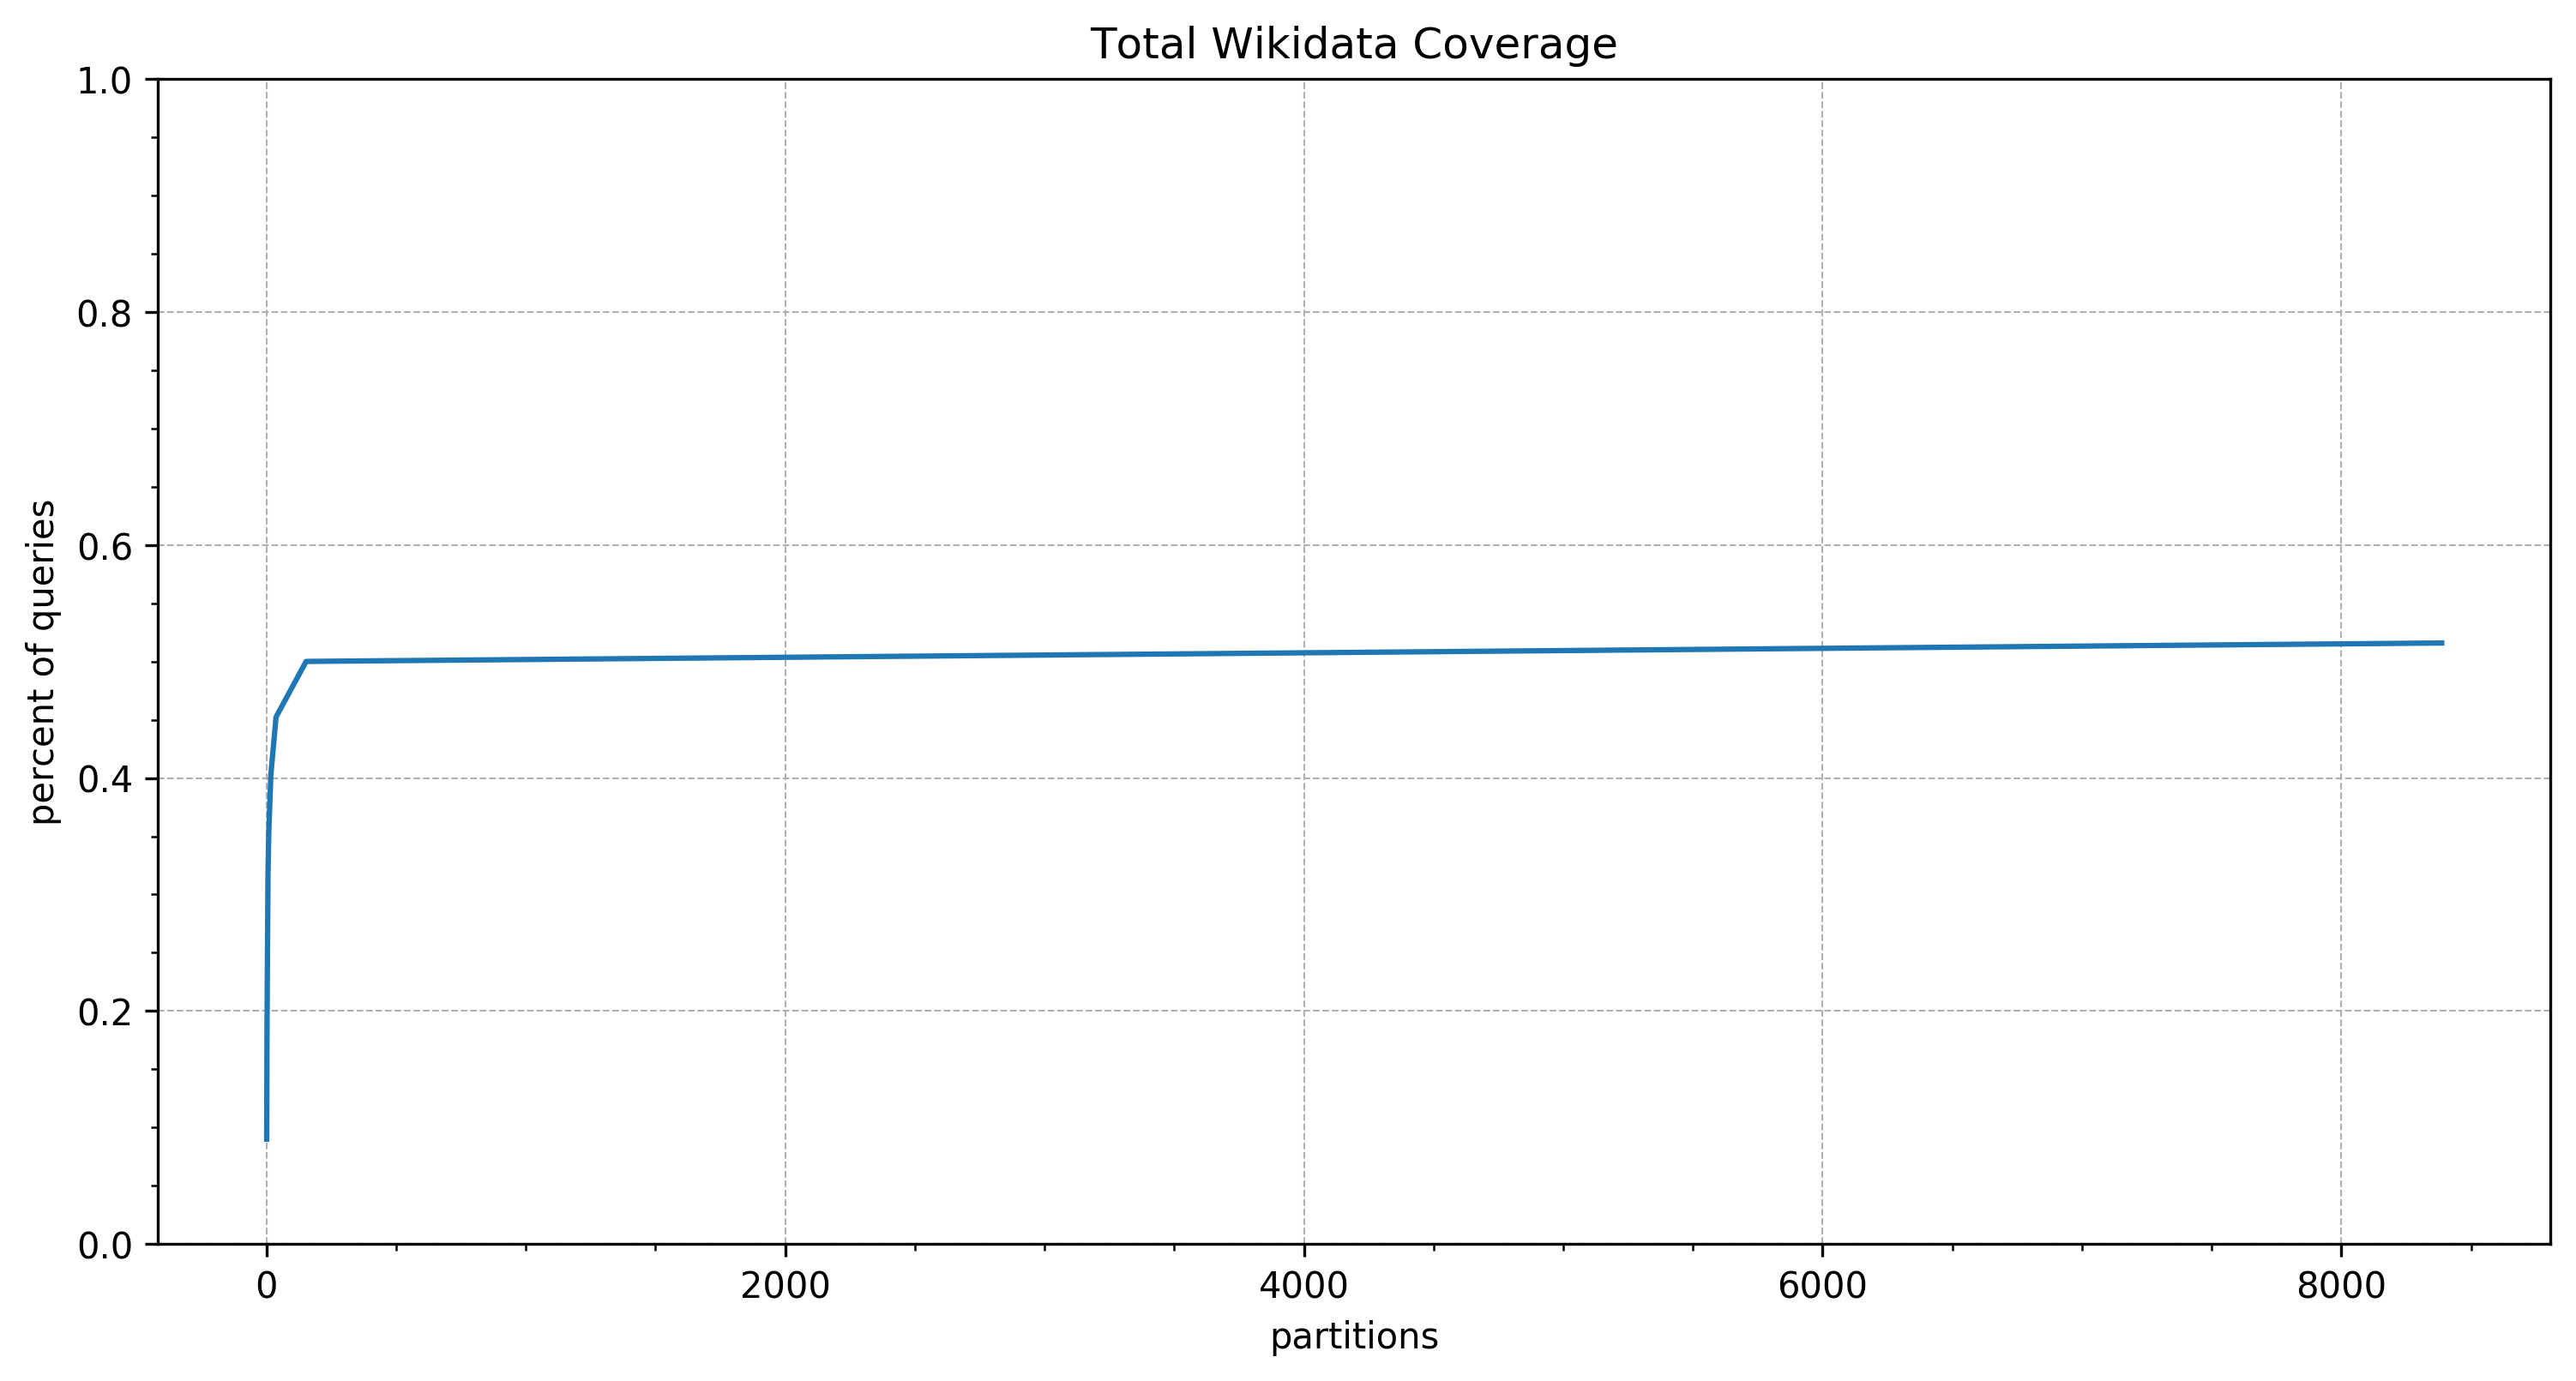

In [157]:
fig, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.set_title('Total Wikidata Coverage')
plot_minimum_unions(all_minimum_unions, axes)

## Organic Queries

In [27]:
organic_df, total_organic_lines = import_combined([f"../queryshapes_wikidata_organic_{part}.tsv" for part in parts])

In [146]:
organic_alt_df = organic_df[organic_df["weight"] > 5]

In [147]:
organic_minimum_unions = minimum_union_for_thresholds(organic_alt_df, total_organic_lines, thresholds)

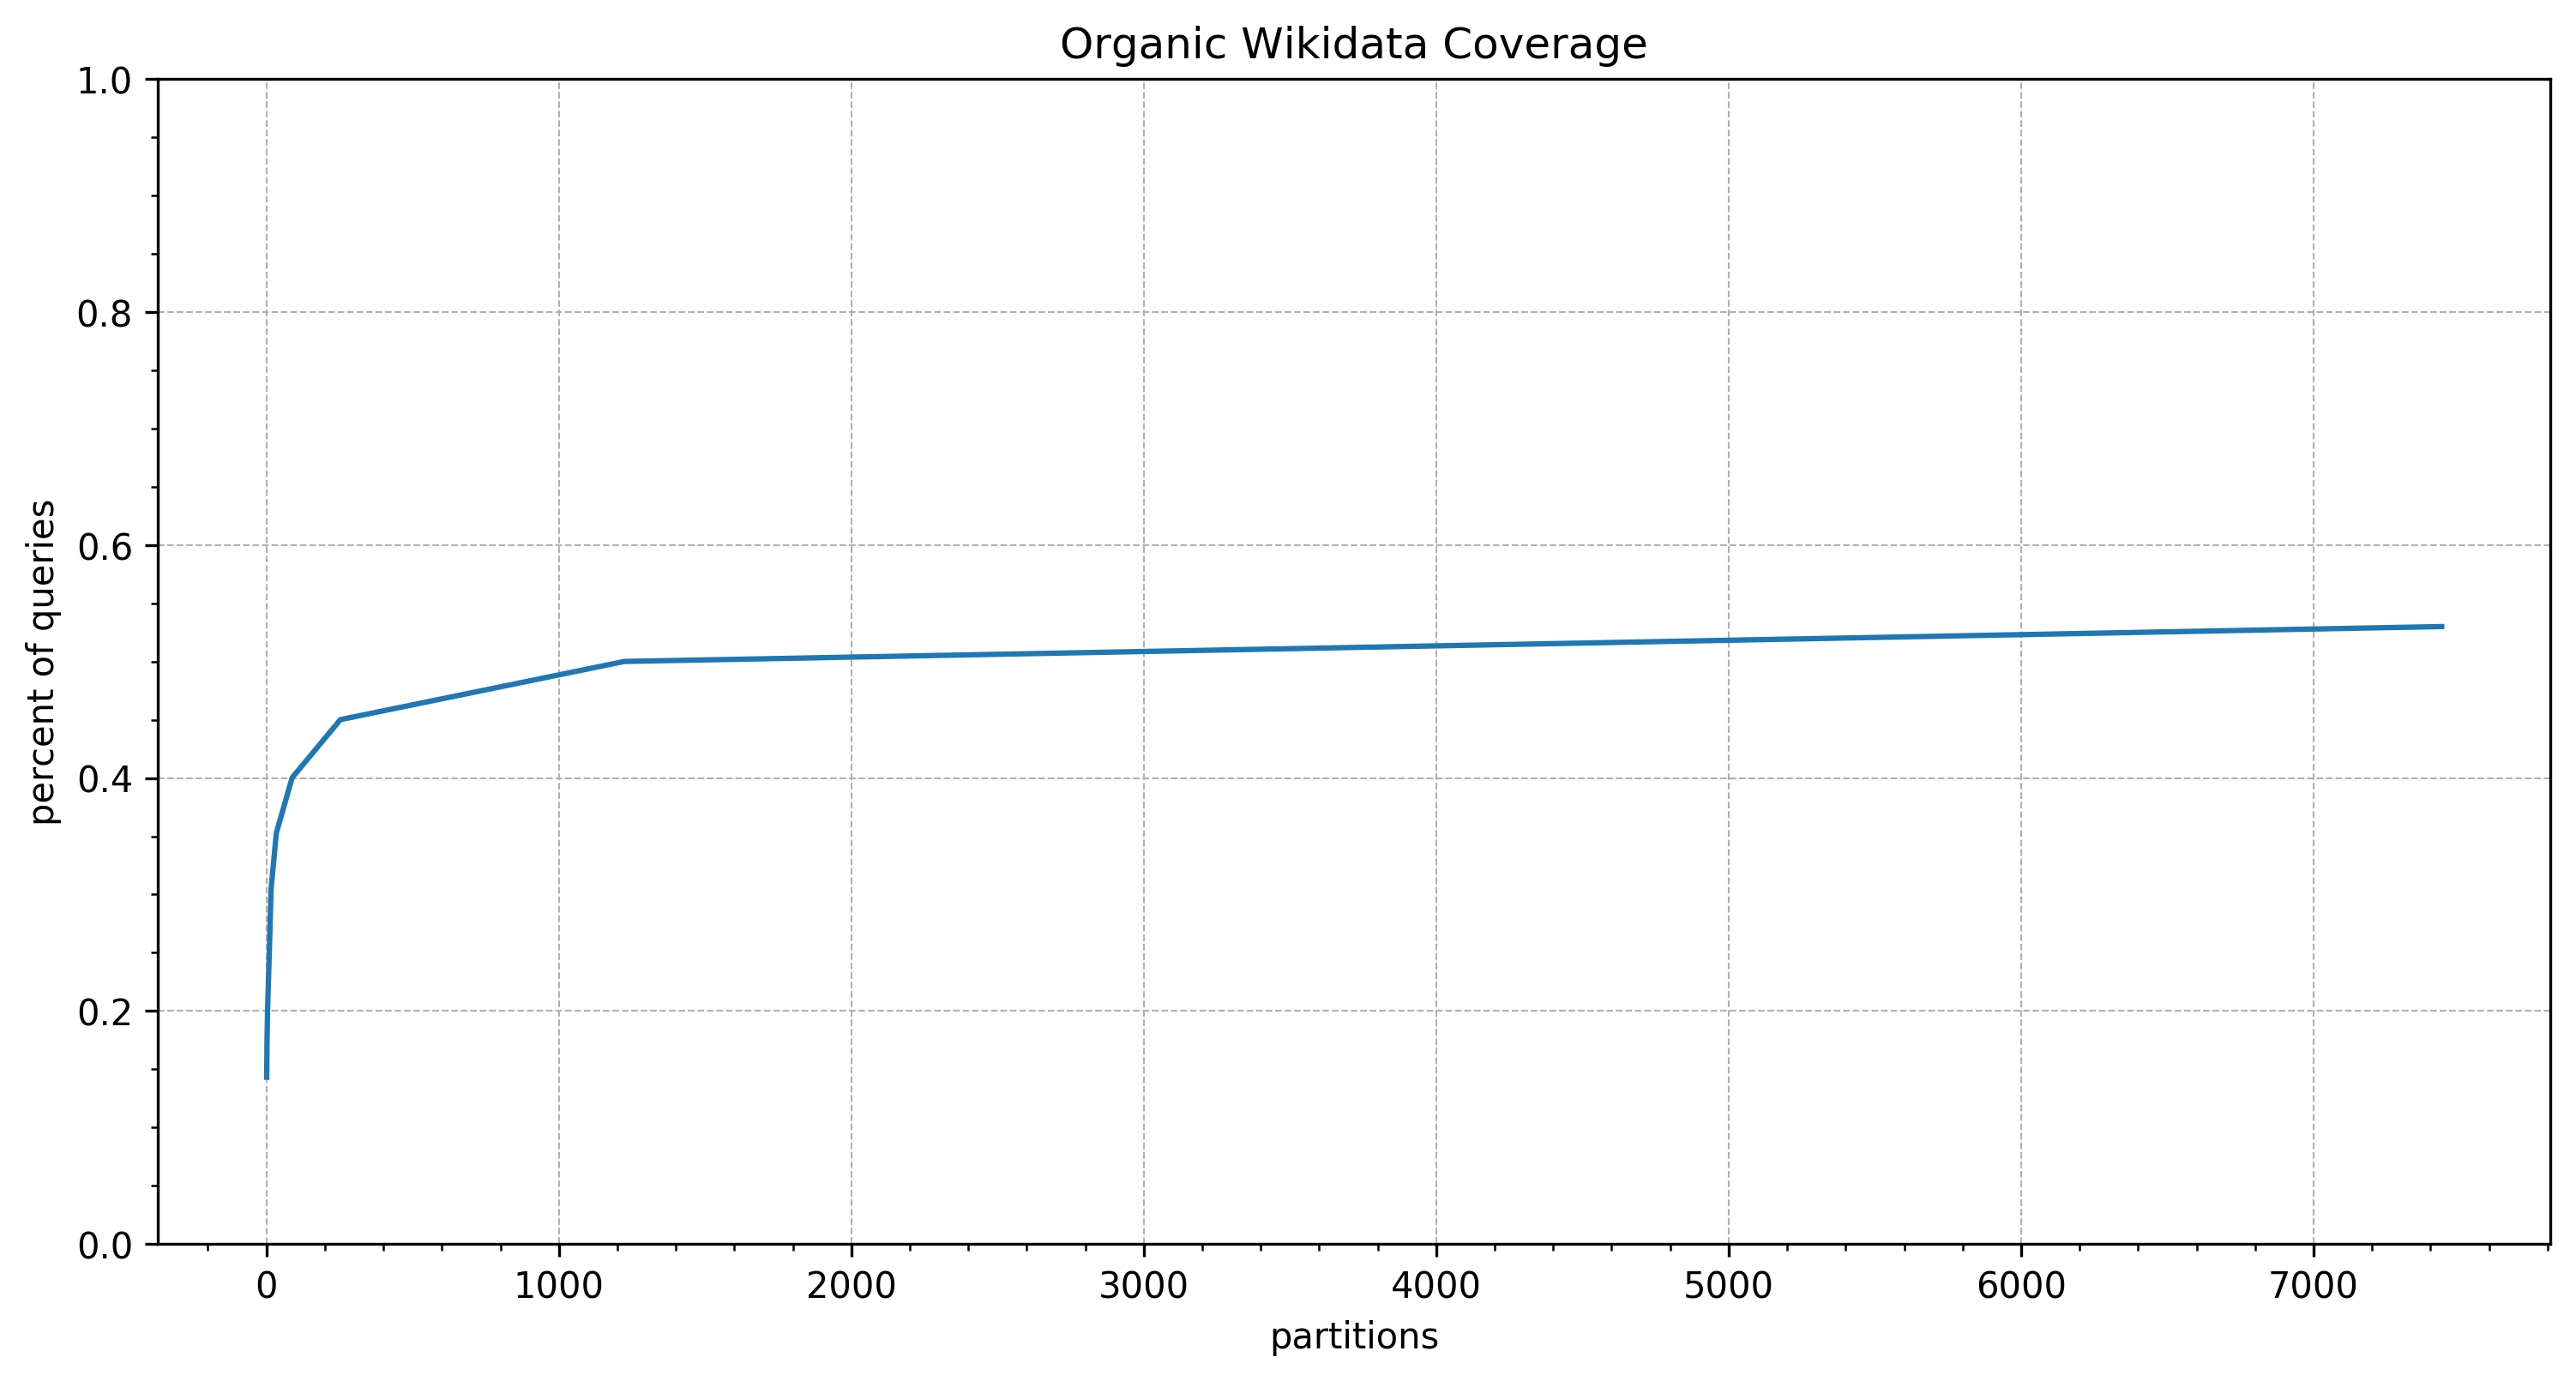

In [166]:
fig, axes = plt.subplots(figsize=(12,6),dpi=300)
axes.set_title('Organic Wikidata Coverage')
plot_minimum_unions(organic_minimum_unions, axes)

In [165]:
import pickle
with open("../all_minimum_unions.pickle", "wb") as file:
    pickle.dump(all_minimum_unions, file)
    

## Development over time

In [6]:
import json
import pandas as pd
parts = [1,2,3,4,5,6,7]
all_dfs = [import_statistics(f"../queryshapes_wikidata_all_{part}.tsv") for part in parts]
thresholds = list(range(5, 70, 5))
max_cov = [df["weight"].sum() / query_count for query_count, df in all_dfs]

In [51]:
all_alt_dfs = [(query_count, df[df["weight"] > 100]) for query_count, df in all_dfs]
all_dfs_minimum_unions = [minimum_union_for_thresholds(df, query_count, thresholds) for query_count, df in all_alt_dfs]


In [8]:
import pickle
import itertools
all_dfs_minimum_unions = pickle.load(open("../all_dfs_minimum_unions.pickle", "rb"))
all_dfs_dedup = [list(k for k,_ in itertools.groupby(k)) for k in all_dfs_minimum_unions]


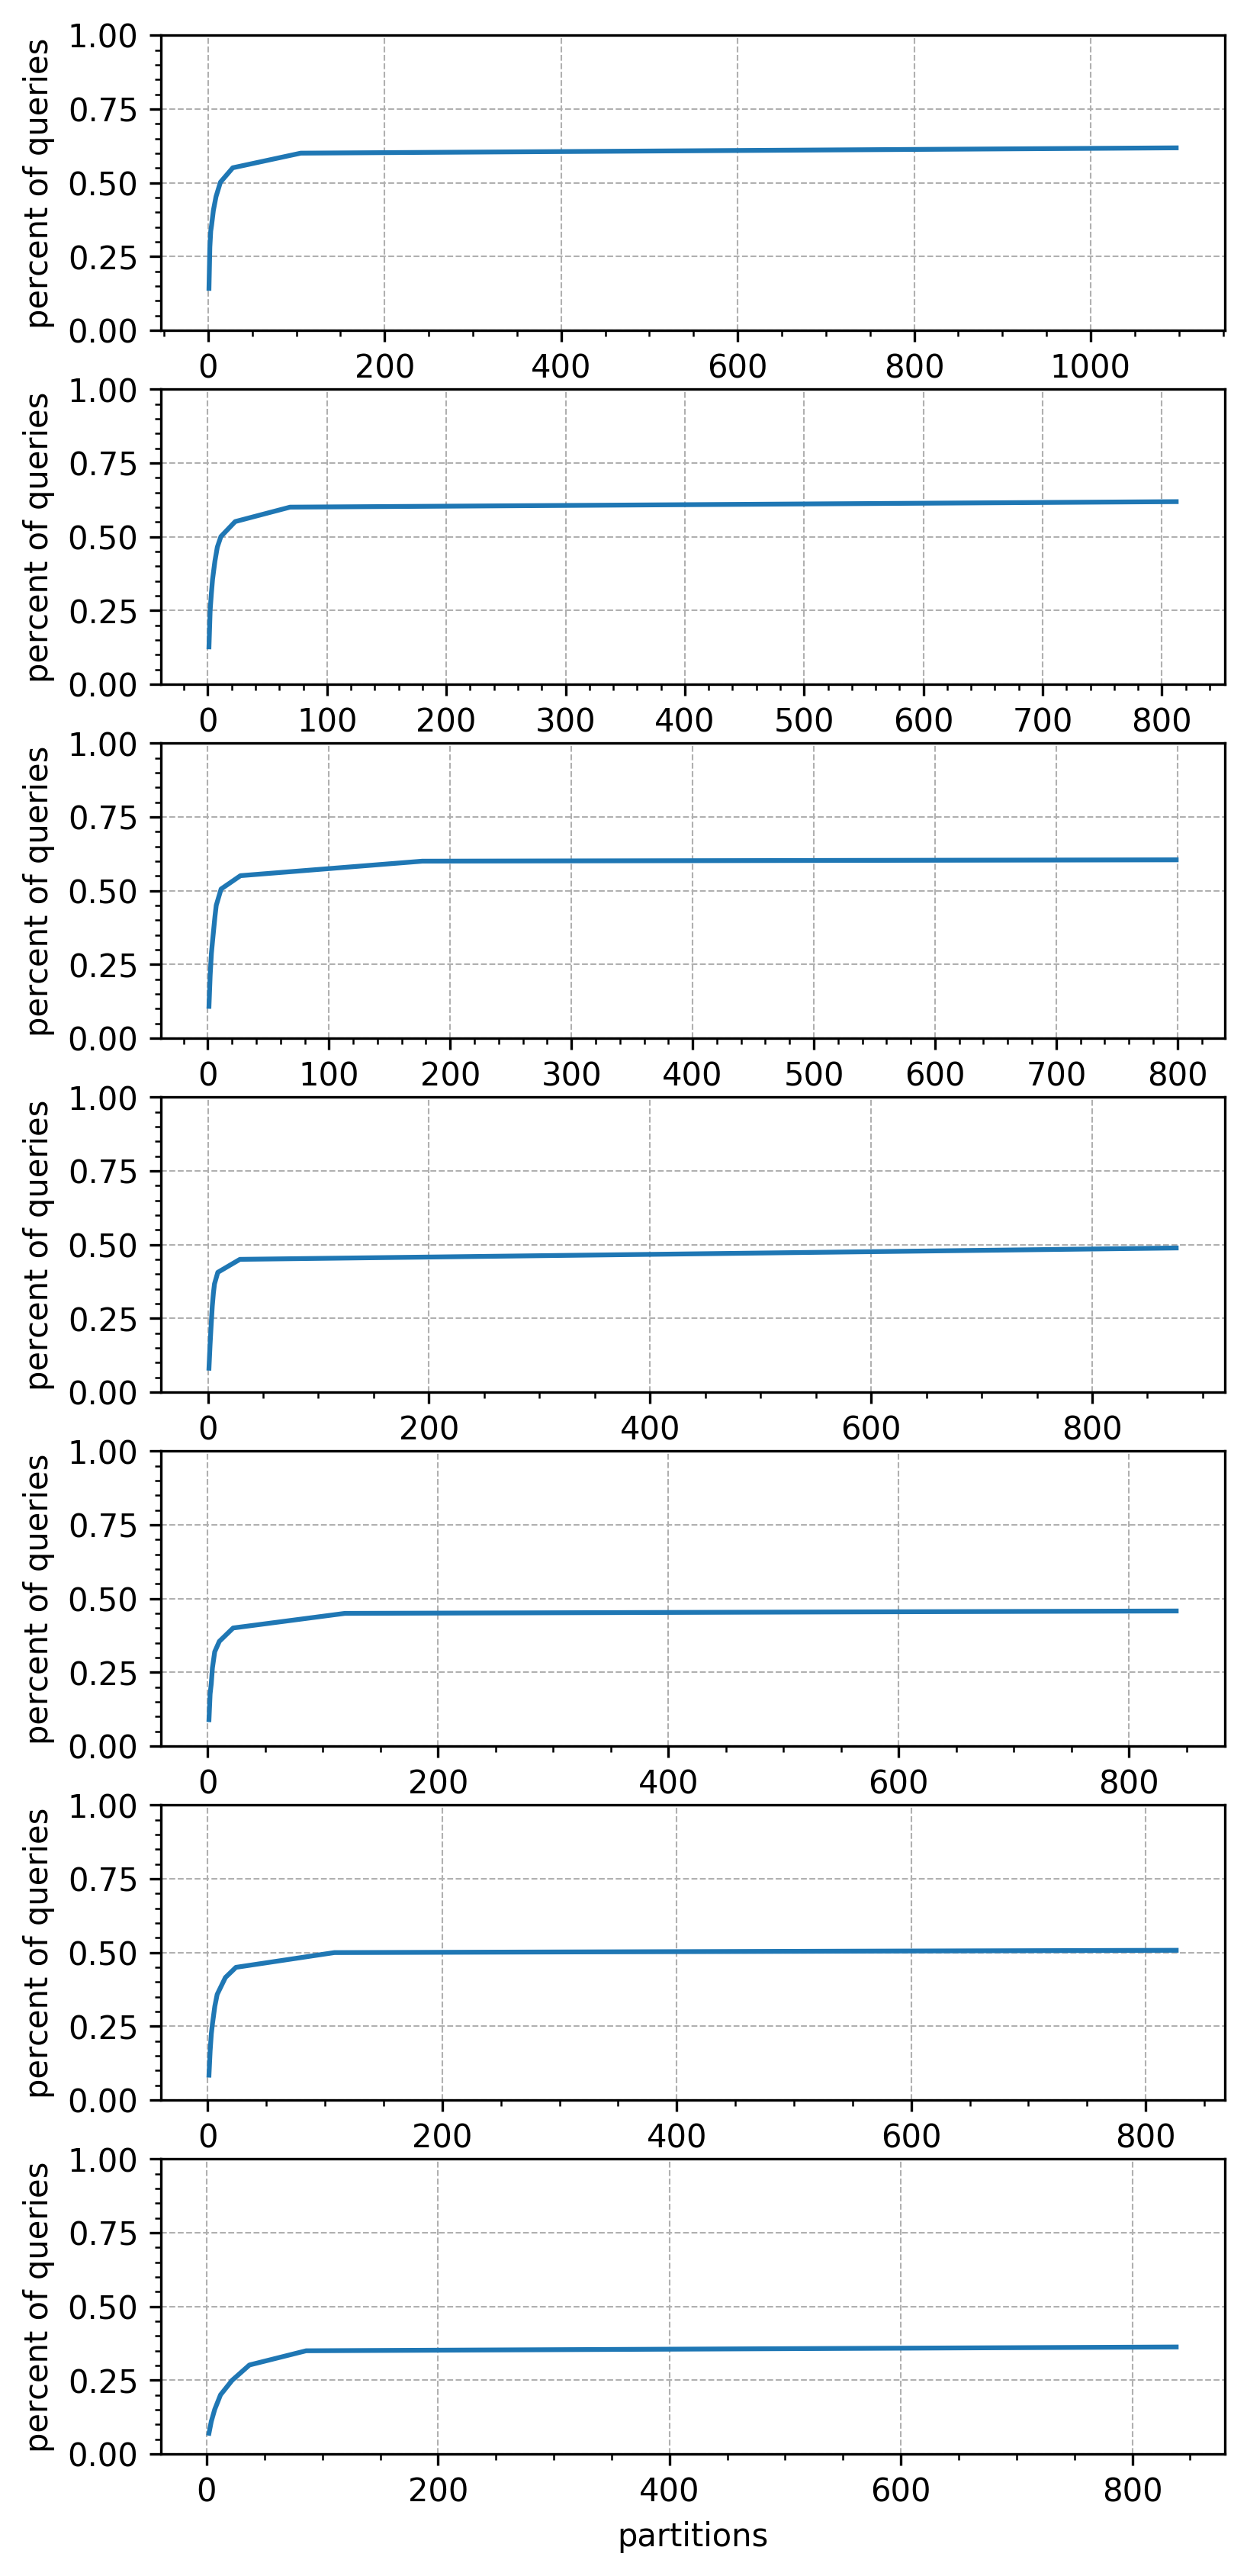

In [28]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(7,1, figsize=(6,14),dpi=300)

for i, min_unions in enumerate(all_dfs_dedup):
    plot_minimum_unions(min_unions, axes[i])

In [31]:
coverage_progression = [None]
for unions_past, shapes_now in zip(all_dfs_dedup[:-1], all_dfs[1:]):
    total_lines_now = shapes_now[0]
    df_now = shapes_now[1]
    coverage_past = unions_past[-1][1]
    sweet_union_set = set(unions_past[-1][0])
    covered_weight_now = df_now.apply(lambda row: row["weight"] if row["set"].issubset(sweet_union_set) else 0, axis=1).sum()
    coverage_progression.append(covered_weight_now / total_lines_now)
print(coverage_progression)    

[None, 0.5998842423490478, 0.5922643983443805, 0.46753767761543813, 0.450089373694412, 0.4948475983459859, 0.3281566103701198]


[(0, 1)]

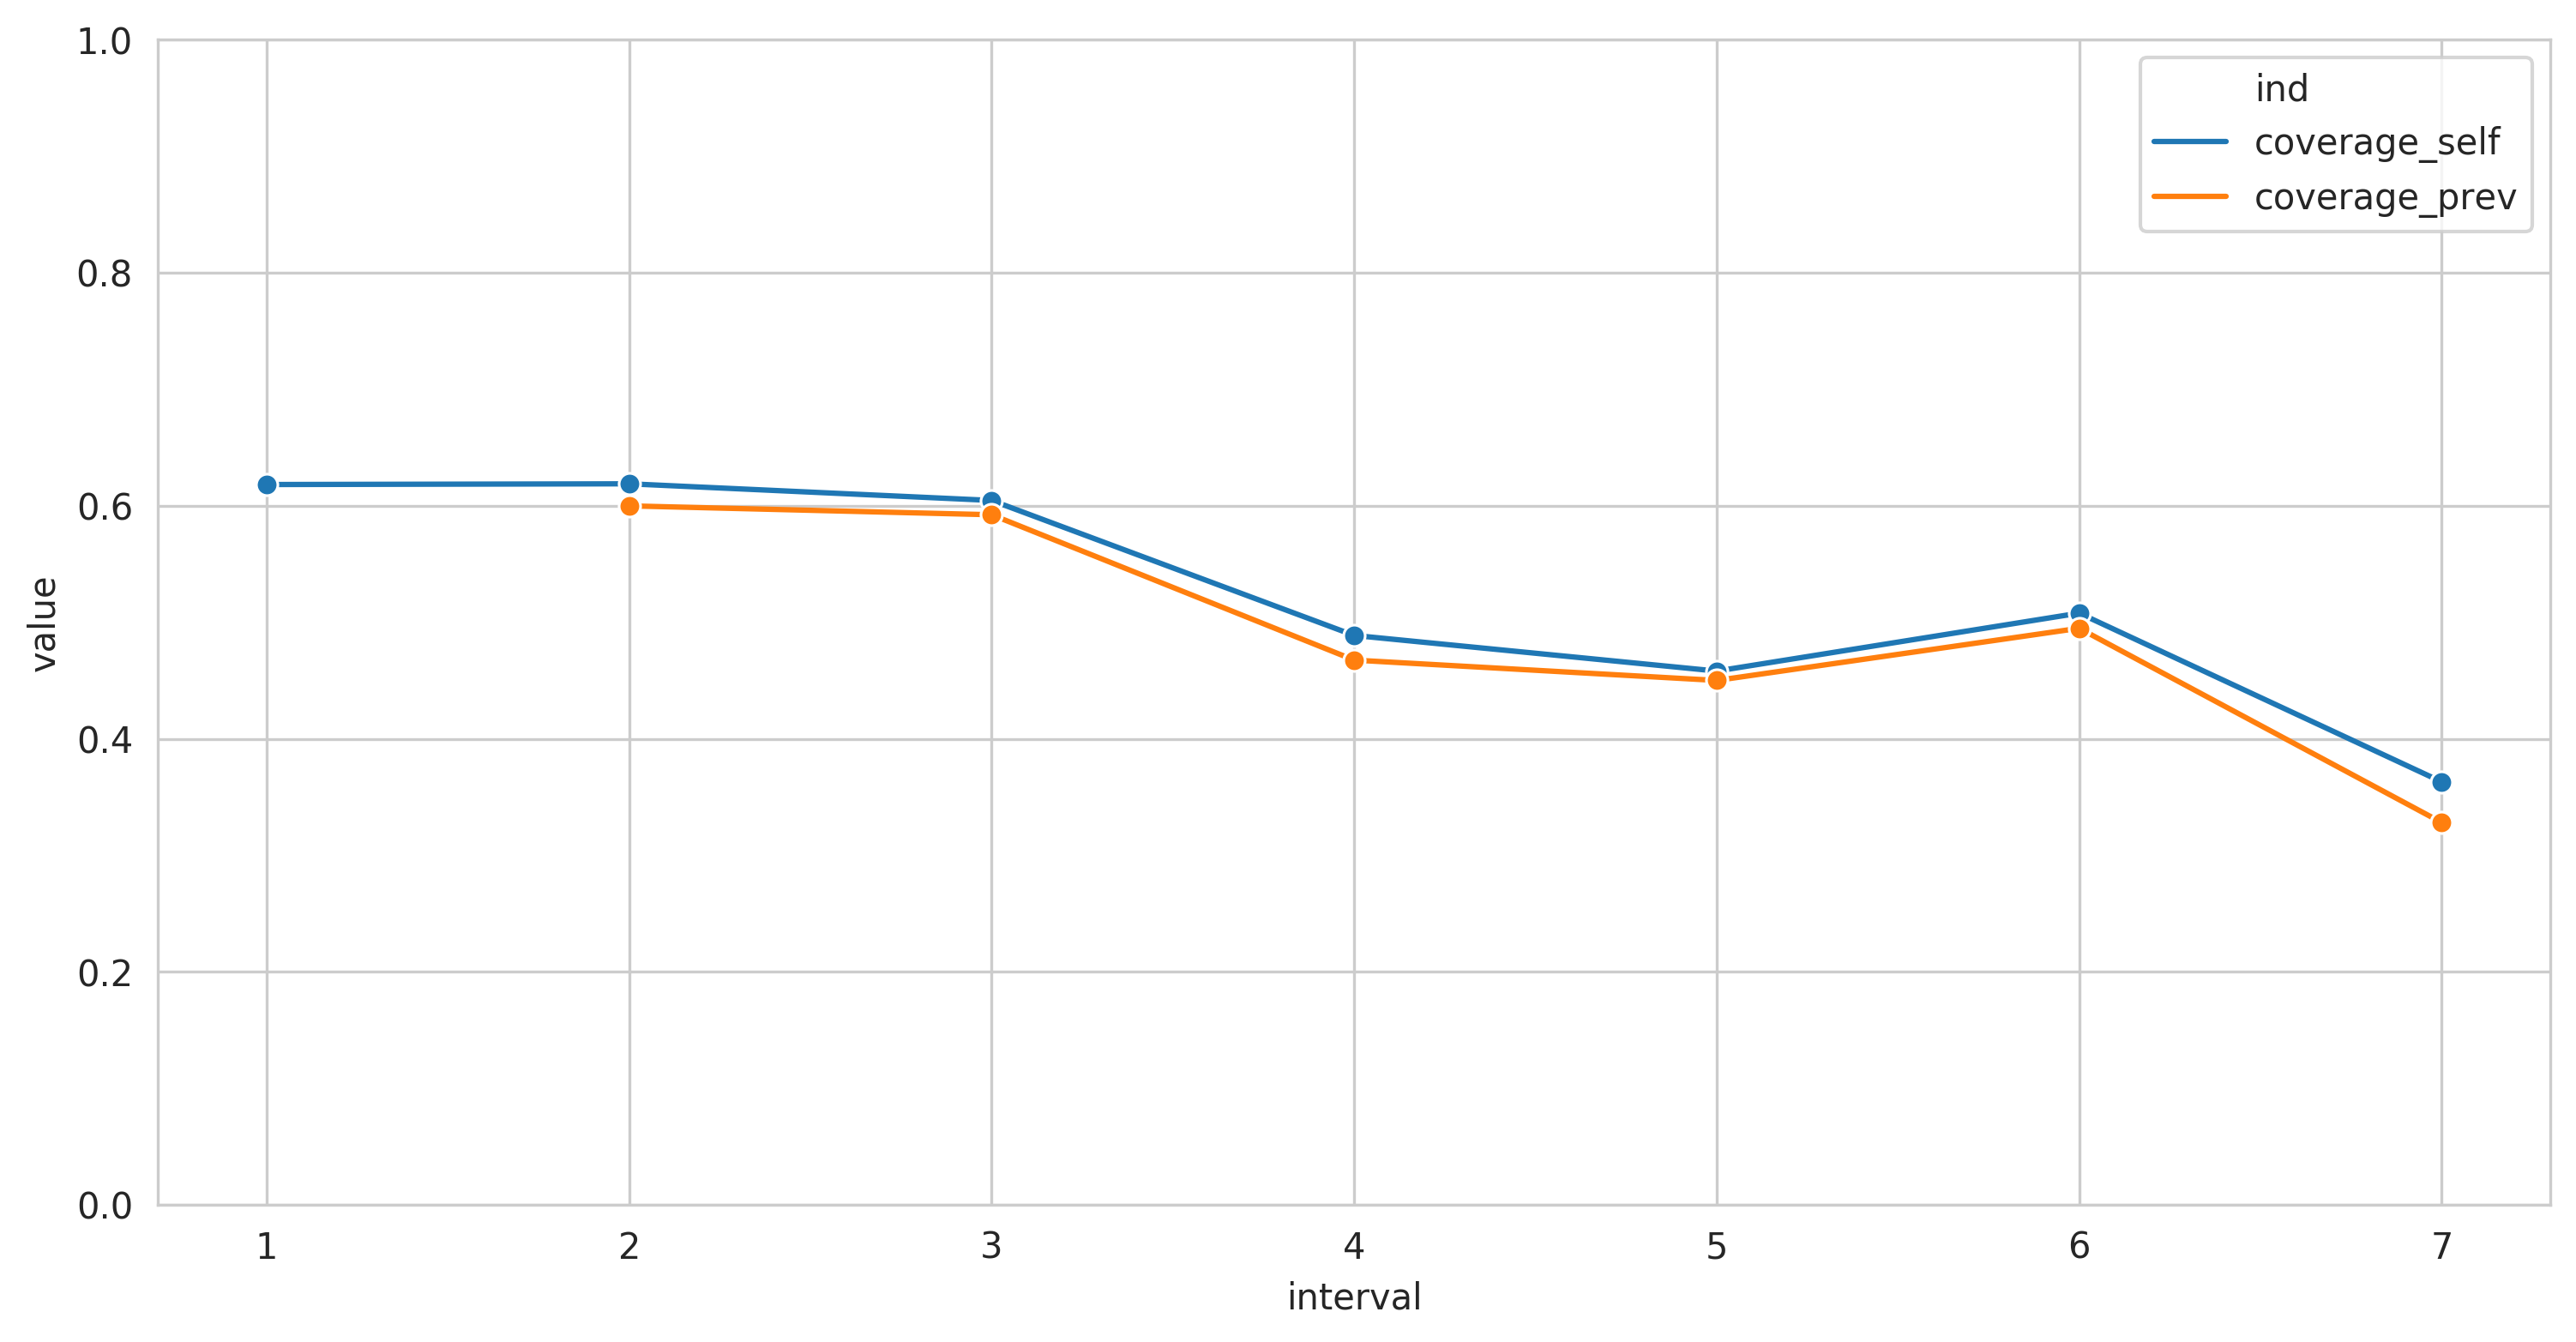

In [48]:
import seaborn as sns
sns.set_style("whitegrid")
plot_df = pd.DataFrame()
plot_df["interval"] = range(1,8)
plot_df["coverage_self"] = [unions[-1][1] for unions in all_dfs_dedup]
plot_df["coverage_prev"] = coverage_progression
plot_df = plot_df.melt(id_vars=["interval"], var_name="ind", value_name="value")

fig, ax = plt.subplots(figsize=(12,6), dpi=300)
g = sns.lineplot(ax=ax, x="interval", y="value", hue="ind",  data=plot_df, marker="o")
g.set(ylim=(0,1))

In [54]:
parts = [1,2,3,4,5,6,7]
organic_dfs = [import_statistics(f"../queryshapes_wikidata_organic_{part}.tsv") for part in parts]
thresholds = list(range(5, 70, 5))
max_cov = [df["weight"].sum() / query_count for query_count, df in organic_dfs]

In [21]:
organic_dfs_minimum_unions = [minimum_union_for_thresholds(df, query_count, thresholds) for query_count, df in organic_dfs]

In [23]:
import pickle
with open("../organic_dfs_minimum_unions.pickle", "wb") as file:
    pickle.dump(organic_dfs_minimum_unions, file)

In [50]:
import pickle
import itertools
organic_dfs_minimum_unions = pickle.load(open("../organic_dfs_minimum_unions.pickle", "rb"))
organic_dfs_dedup = [list(k for k,_ in itertools.groupby(k)) for k in organic_dfs_minimum_unions]

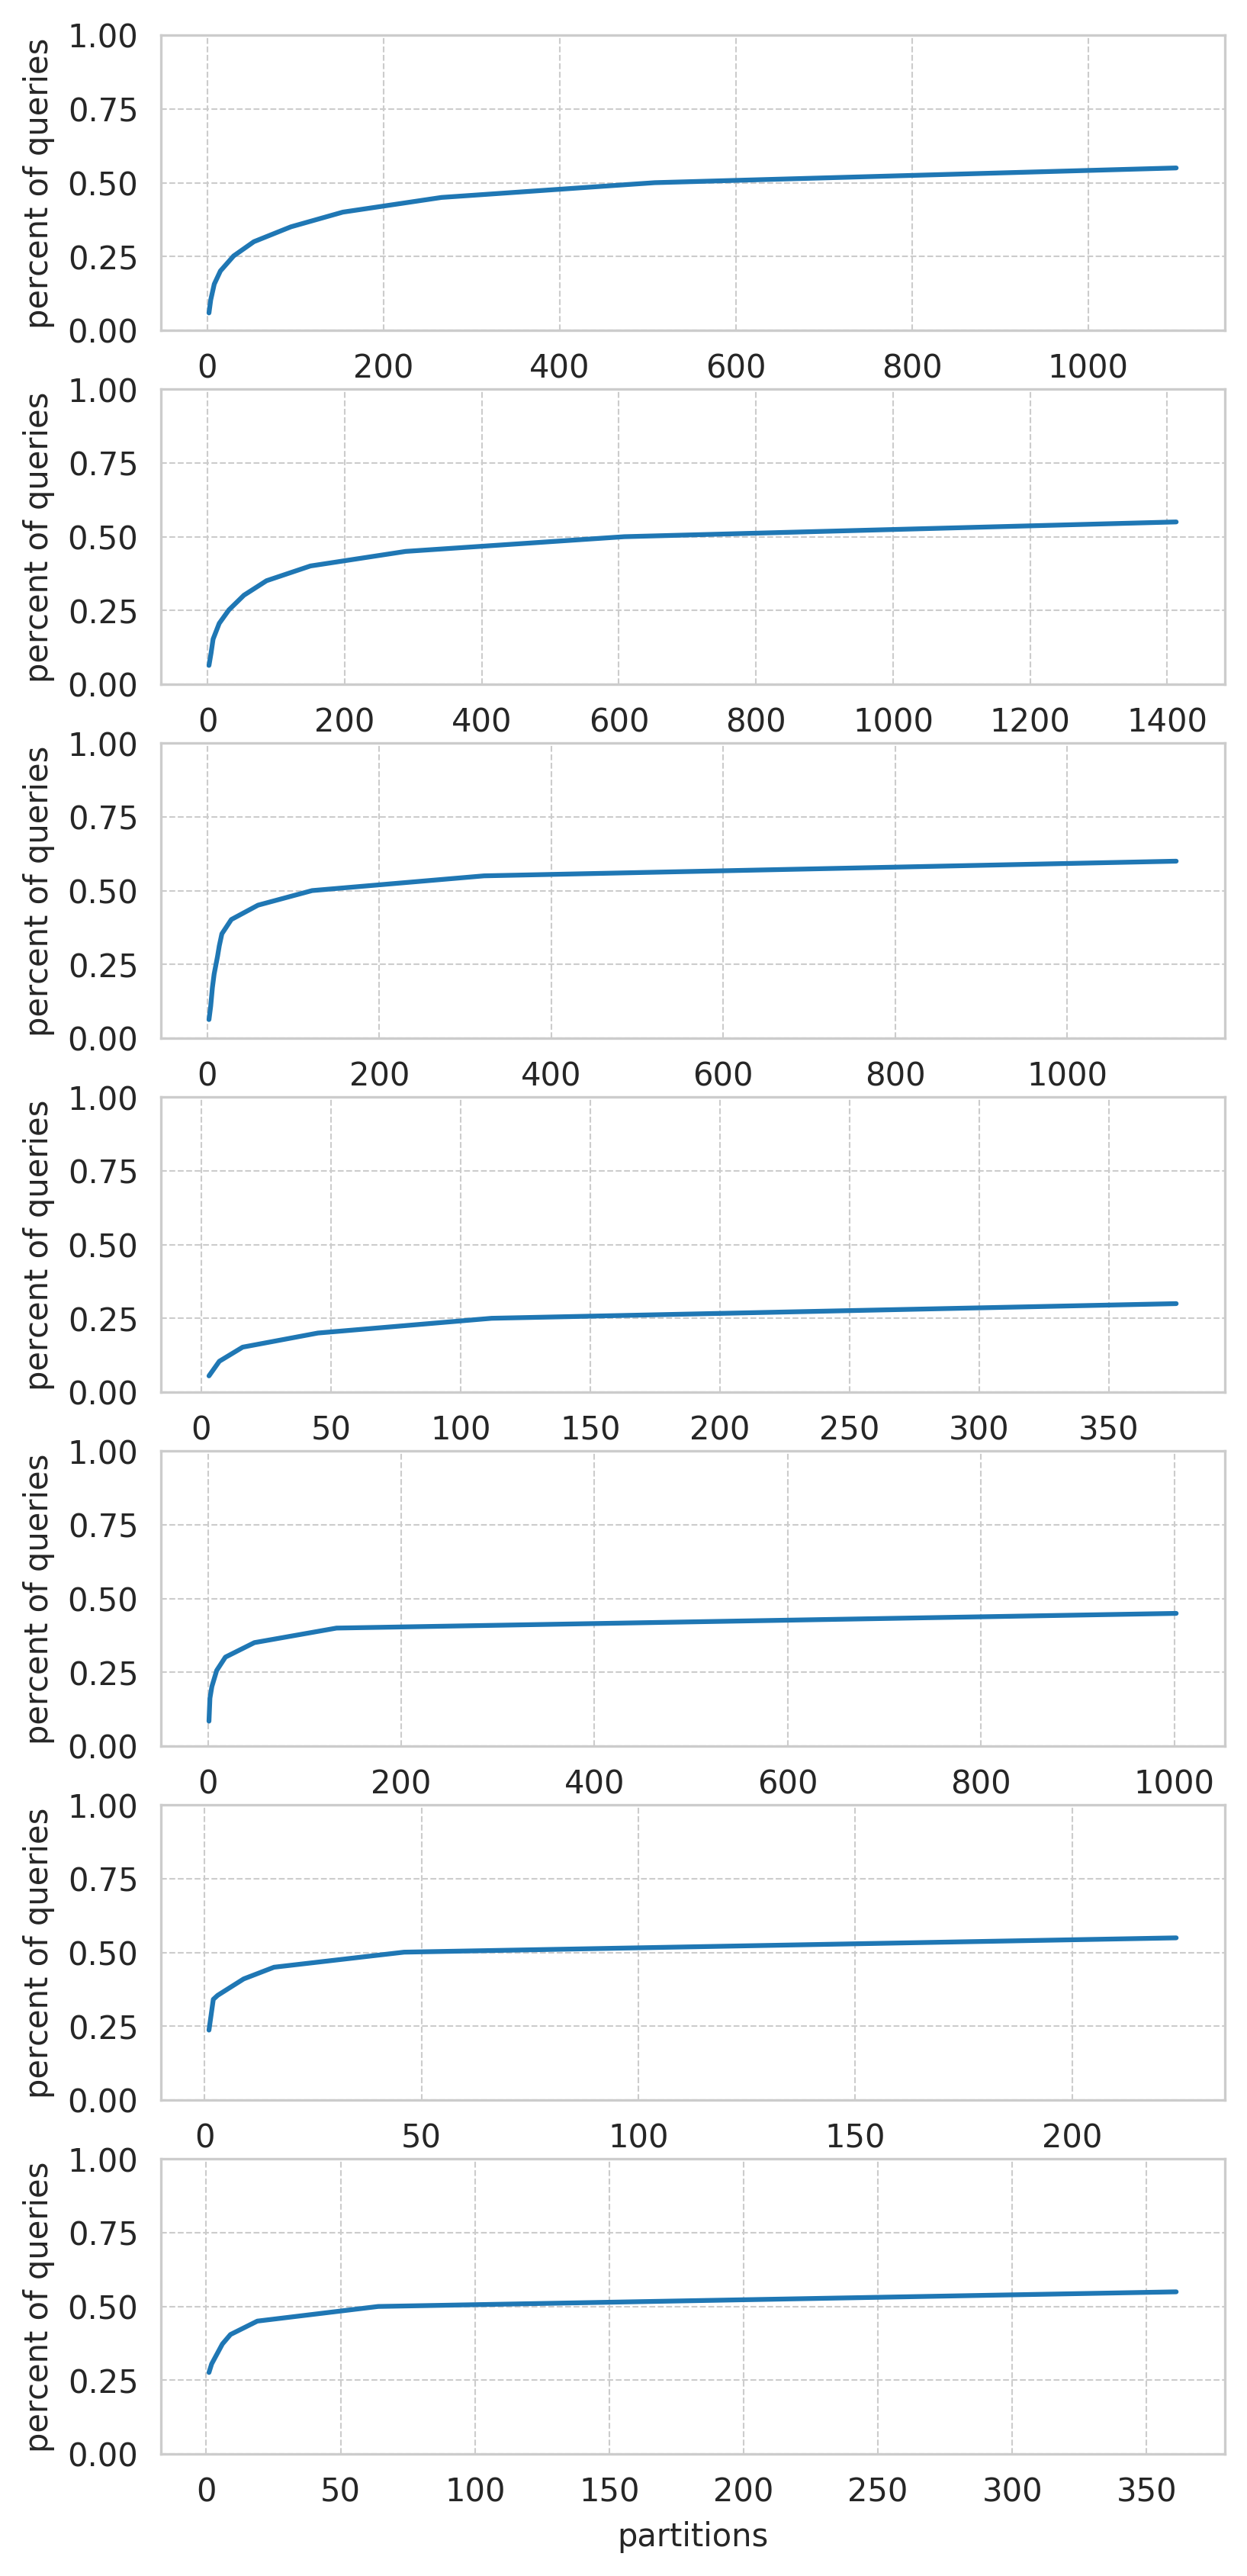

In [51]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(7,1, figsize=(6,14),dpi=300)

subset = [-2, -2, -1, -2, -1, -2, -1]

for i, min_unions in enumerate(organic_dfs_dedup):
    plot_minimum_unions(min_unions[:subset[i]], axes[i])

In [55]:
coverage_progression_organic = [None]
for (i, (unions_past, shapes_now)) in enumerate(zip(organic_dfs_dedup[:-1], organic_dfs[1:])):
    total_lines_now = shapes_now[0]
    df_now = shapes_now[1]
    coverage_past = unions_past[subset[i] -1][1]
    sweet_union_set = set(unions_past[subset[i] -1][0])
    covered_weight_now = df_now.apply(lambda row: row["weight"] if row["set"].issubset(sweet_union_set) else 0, axis=1).sum()
    coverage_progression_organic.append(covered_weight_now / total_lines_now)
print(coverage_progression_organic)    

[None, 0.40835379838038605, 0.5468393595157975, 0.1831676495027473, 0.29805468825818804, 0.5384507572869528, 0.454130951258386]


[(0, 1)]

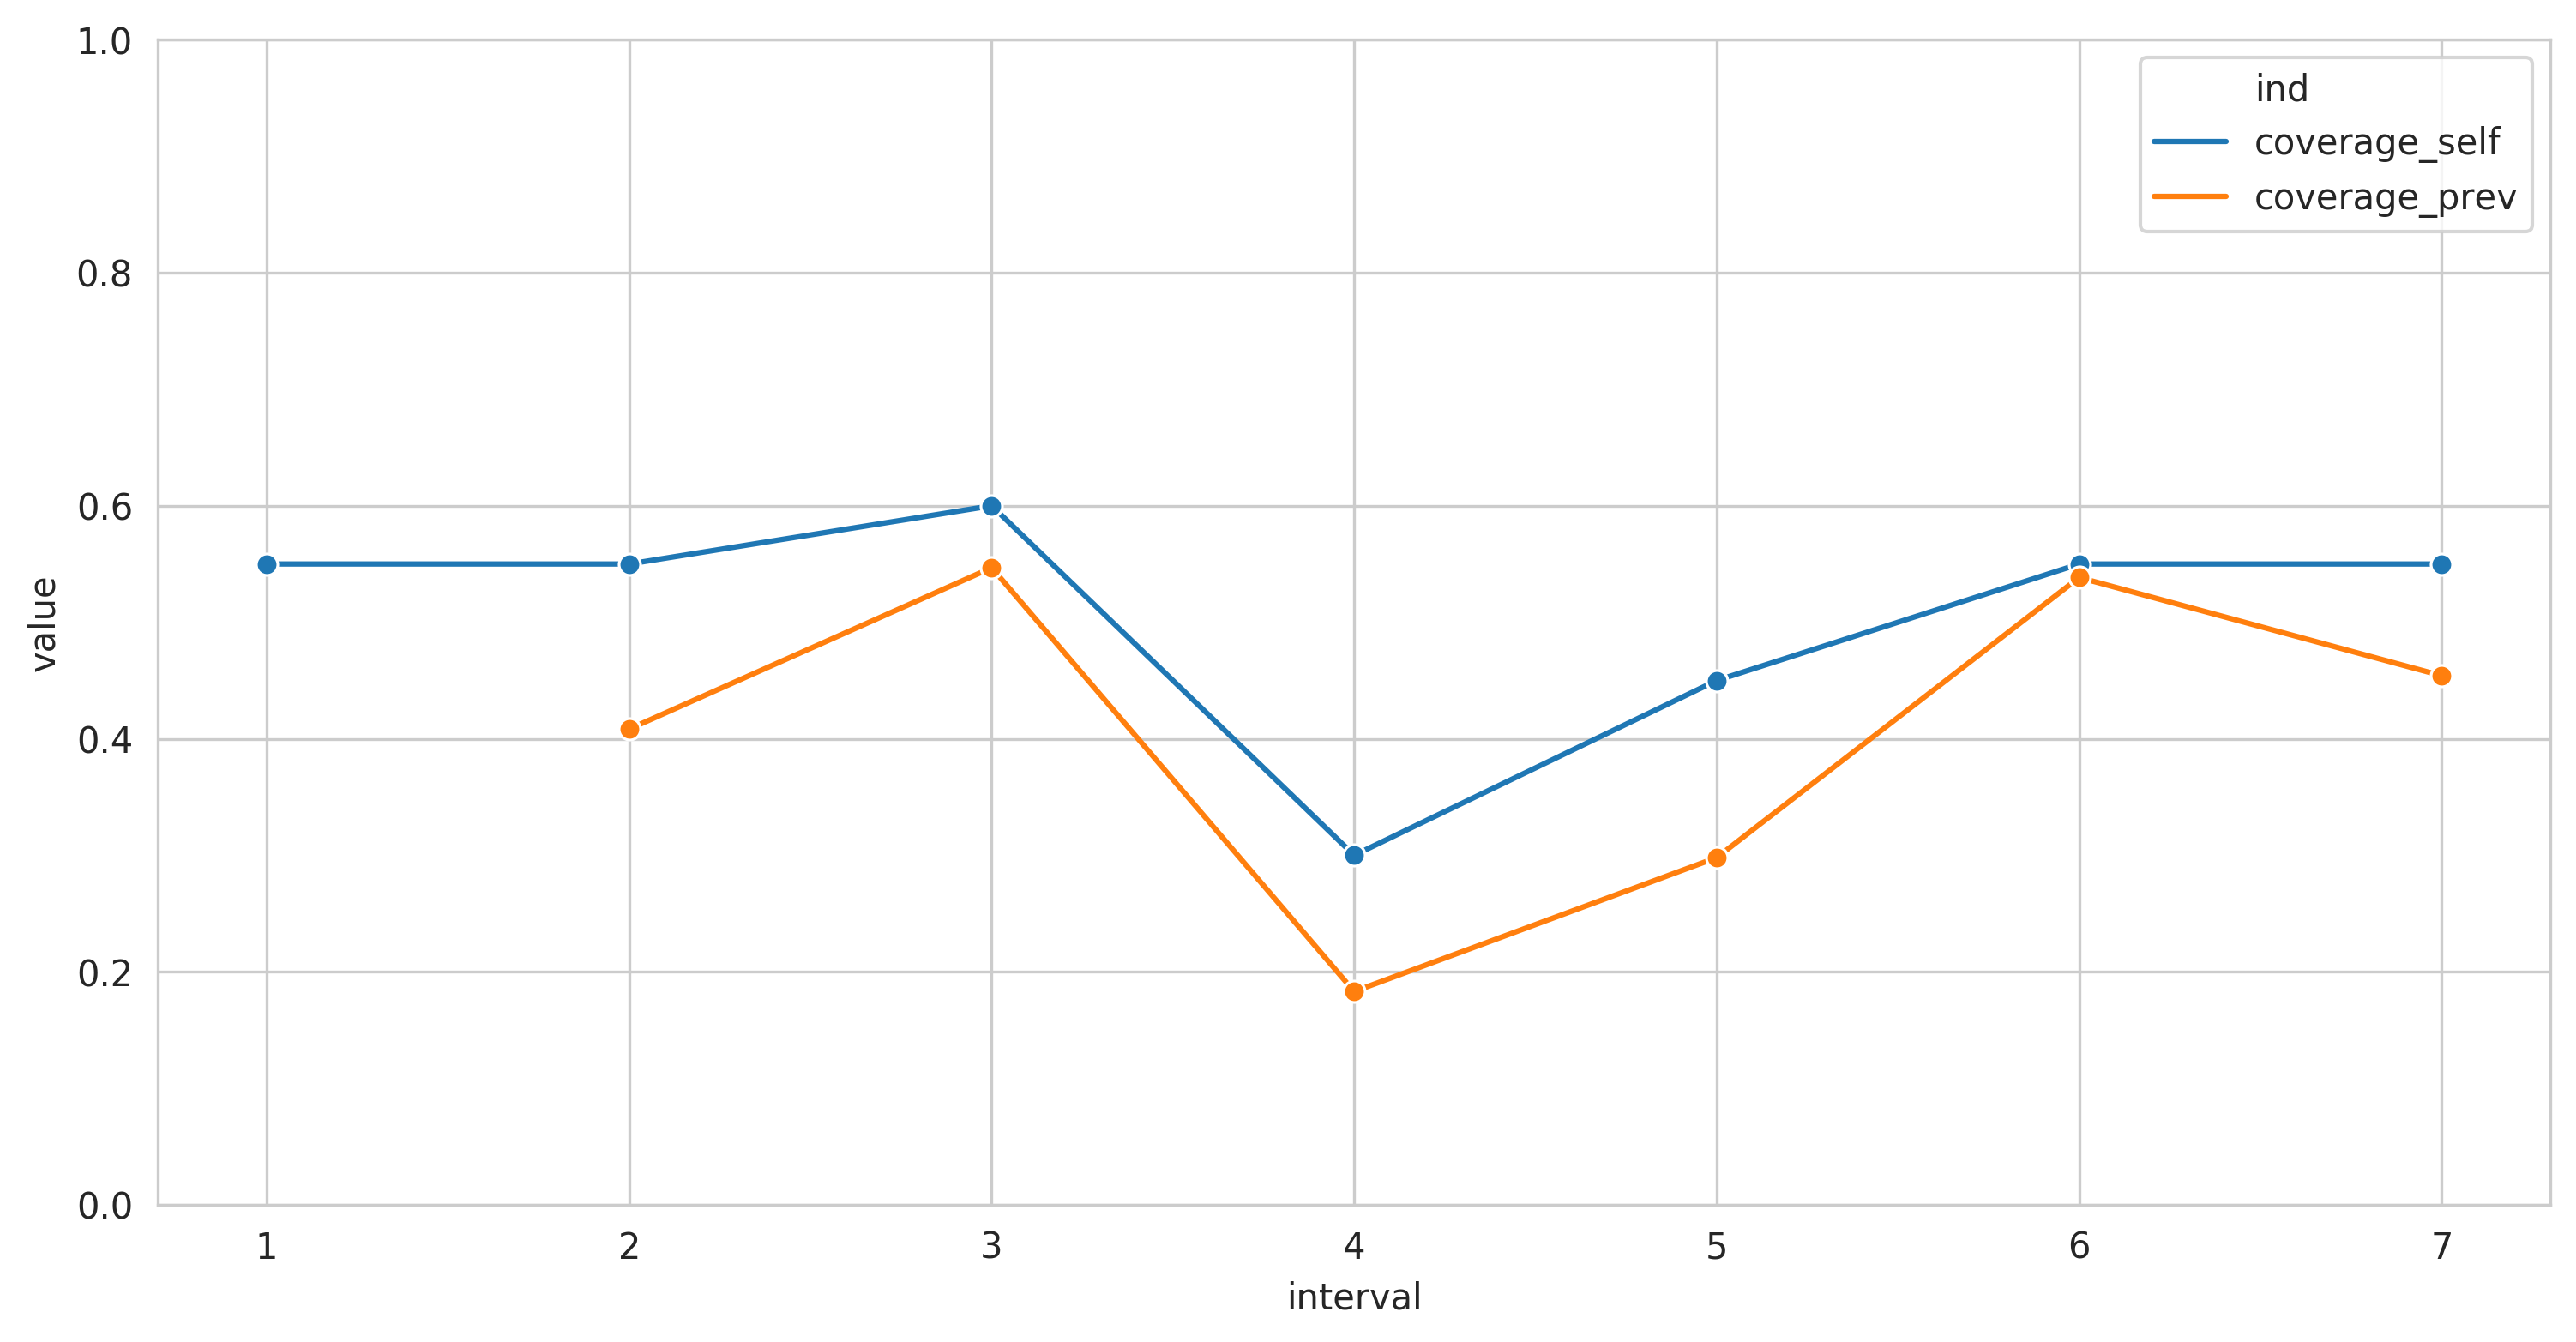

In [56]:
import seaborn as sns
sns.set_style("whitegrid")
plot_df = pd.DataFrame()
plot_df["interval"] = range(1,8)
plot_df["coverage_self"] = [unions[subset[i] -1][1] for i, unions in enumerate(organic_dfs_dedup)]
plot_df["coverage_prev"] = coverage_progression_organic
plot_df = plot_df.melt(id_vars=["interval"], var_name="ind", value_name="value")

fig, ax = plt.subplots(figsize=(12,6), dpi=300)
g = sns.lineplot(ax=ax, x="interval", y="value", hue="ind",  data=plot_df, marker="o")
g.set(ylim=(0,1))